In [ ]:
import os
import shutil
import ast
import pandas as pd
from pathlib import Path
from typing import List
import sys
import nbformat
from git import Repo, GitCommandError
from langchain.vectorstores import FAISS
from langchain_core.documents import Document
from langchain.chat_models import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from docx import Document as DocxDocument
from itertools import chain
from openai import OpenAI
client = OpenAI()

# Reading the repo and chunking

In [12]:
def is_low_value_file(filepath):
    low_value_exts = [
        '.css', '.min.js', '.json', '.svg', '.csv', '.xlsx', '.xls',
        '.log', '.lock', '.pyc', '.pyo', '.pyd', '.class', '.jar', '.war',
        '.o', '.obj', '.dll', '.exe', '.so', '.a', '.db', '.sqlite', '.sqlite3',
        '.bak', '.tmp', '.ico', '.icns', '.pdf', '.docx', '.pptx',
        '.7z', '.zip', '.tar', '.gz', '.rar', '.iml'
    ]

    low_value_files = [
        'readme.md', 'license', '.gitignore', '.gitattributes', 'post-update.sample',
        'fsmonitor-watchman.sample', 'pre-commit', 'pre-push', 'commit-msg',
        'tags', 'head', 'config', 'description', 'index', '.editorconfig',
        '.prettierrc', '.eslintrc', '.gitmodules', '.mailmap', '.clang-format',
        'pipfile.lock', 'yarn.lock', 'package-lock.json', '.env', '.env.example', '.npmrc',
        'update.sample'
    ]

    low_value_dirs = {
        '.git', '.vscode', '.idea', '__pycache__',
        'node_modules', 'dist', 'build', '.pytest_cache'
    }

    filepath_str = str(filepath).lower()
    parts = set(Path(filepath).parts)

    return (
        Path(filepath).suffix.lower() in low_value_exts or
        os.path.basename(filepath).lower() in low_value_files or
        any(d in parts for d in low_value_dirs) or
        'mock' in filepath_str
    )


In [13]:
import tempfile, shutil, os, stat
from pathlib import Path
from git import Repo

def _on_rm_error(func, path, exc_info):
    try:
        os.chmod(path, stat.S_IWRITE)
    except Exception:
        pass
    func(path)

def clone_repo(repo_url, clone_path=None) -> str:
    # Use a fresh temp dir by default to avoid collisions
    if clone_path is None:
        clone_path = tempfile.mkdtemp(prefix="repo_")
    cp = Path(clone_path)

    if cp.exists():
        shutil.rmtree(cp, onerror=_on_rm_error)

    Repo.clone_from(repo_url, str(cp), depth=1)
    return str(cp)

In [20]:
def extract_all_chunks(repo_path: str, index_dir: str = "docs_index") -> list[Document]:
    chunks = []
    repo_path = Path(repo_path)

    # 1. README files
    for readme_name in ("README.md", "README.rst", "README.txt"):
        readme_path = repo_path / readme_name
        if readme_path.exists():
            content = readme_path.read_text(encoding="utf-8").strip()
            if 50 < len(content) < 5000:
                chunks.append(Document(
                    page_content=content,
                    metadata={
                        "source": str(readme_path),
                        "file_ext": "text",
                        "type": "readme",
                        "name": readme_name,
                        "lines": f"1-{content.count(chr(10)) + 1}"
                    }
                ))
            break

    # 2. Other Markdown files
    # 2. Other text files (Markdown/RST/TXT)
    for text_path in chain(
        repo_path.rglob("*.md"),
        repo_path.rglob("*.rst"),
        repo_path.rglob("*.txt"),
    ):
        if text_path.name.lower() == "readme.md":
            continue
        try:
            content = text_path.read_text(encoding="utf-8").strip()
            if 50 < len(content) < 5000:
                ext = text_path.suffix.lower().lstrip(".") or "txt"  # <- suffix as type/ext
                chunks.append(Document(
                    page_content=content,
                    metadata={
                        "source": str(text_path),
                        "file_ext": ext,     # was "markdown"
                        "type": ext,         # was "markdown" — now suffix-based
                        "name": text_path.name,
                        "lines": f"1-{content.count(chr(10)) + 1}",
                    }
                ))
        except Exception:
            continue

    # 3. Code and misc files
    for filepath in repo_path.rglob("*.*"):
        if is_low_value_file(filepath):
            continue

        try:
            suffix = filepath.suffix.lower()

            # 3a. Python files
            if suffix == ".py":
                code = filepath.read_text(encoding="utf-8")
                tree = ast.parse(code)

                mod_doc = ast.get_docstring(tree)
                if mod_doc and 50 < len(mod_doc) < 5000:
                    chunks.append(Document(
                        page_content=mod_doc,
                        metadata={
                            "source": str(filepath),
                            "file_ext": "code",
                            "type": "module_docstring",
                            "name": filepath.name,
                            "lines": f"1-{code.count(chr(10)) + 1}"
                        }
                    ))

                for node in tree.body:
                    if isinstance(node, (ast.FunctionDef, ast.ClassDef)):
                        content = ast.get_source_segment(code, node)
                        if content and 50 < len(content) < 5000:
                            chunks.append(Document(
                                page_content=content,
                                metadata={
                                    "source": str(filepath),
                                    "file_ext": "code",
                                    "type": type(node).__name__.lower(),
                                    "name": node.name,
                                    "lines": f"{node.lineno}-{getattr(node, 'end_lineno', node.lineno)}"
                                }
                            ))

                        doc = ast.get_docstring(node)
                        if doc and 50 < len(doc) < 5000:
                            chunks.append(Document(
                                page_content=doc,
                                metadata={
                                    "source": str(filepath),
                                    "file_ext": "code",
                                    "type": f"{type(node).__name__.lower()}_docstring",
                                    "name": node.name,
                                    "lines": f"{node.lineno}-{getattr(node, 'end_lineno', node.lineno)}"
                                }
                            ))

            # 3b. Notebooks
            elif suffix == ".ipynb":
                nb = nbformat.read(filepath, as_version=4)
                for i, cell in enumerate(nb.cells):
                    if cell.cell_type in ("markdown", "code"):
                        content = cell.source.strip()
                        if 50 < len(content) < 5000:
                            chunks.append(Document(
                                page_content=content,
                                metadata={
                                    "source": str(filepath),
                                    "file_ext": "code",
                                    "type": f"{cell.cell_type}_cell",
                                    "name": f"{filepath.name} - cell {i}",
                                    "lines": f"cell_{i}"
                                }
                            ))

            # 3c. Other code/text files
            else:
                code = filepath.read_text(encoding="utf-8")
                if 50 < len(code) < 5000:
                    chunks.append(Document(
                        page_content=code,
                        metadata={
                            "source": str(filepath),
                            "file_ext": "code",
                            "type": suffix,
                            "name": filepath.name,
                            "lines": f"1-{code.count(chr(10)) + 1}"
                        }
                    ))

        except Exception:
            continue

    # Optional FAISS index creation
    # embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
    # vectordb = FAISS.from_documents(chunks, embedding=embeddings)
    # vectordb.save_local(index_dir)

    return chunks

In [184]:
repo_url = "https://github.com/adarshlearnngrow/StepUpYourCareer.AI"
repo_path = clone_repo(repo_url)

# 1️⃣ Build the FAISS DB from your repo
chunks = extract_all_chunks(repo_path)



In [185]:
len(chunks)

60

In [148]:
# pip install langchain-openai langchain-community faiss-cpu
from pathlib import Path
from typing import List
import hashlib, json, os

from langchain_core.documents import Document  # or: from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

# --- helpers ---------------------------------------------------------------

def _stable_id(doc: Document) -> str:
    meta_json = json.dumps(doc.metadata or {}, sort_keys=True, ensure_ascii=False)
    return hashlib.md5((doc.page_content + "||" + meta_json).encode("utf-8")).hexdigest()

def _norm_ext(ext: str) -> str:
    ext = (ext or "").lower().lstrip(".")
    return ext

def _guess_ext(doc: Document) -> str:
    # 1) try metadata.file_ext
    ext = _norm_ext(str(doc.metadata.get("file_ext", "")))
    # some pipelines put "code" there; treat as unknown
    if ext in {"", "code"}:
        # 2) try source path
        src = str(doc.metadata.get("source", ""))
        if src:
            ext = _norm_ext(Path(src).suffix)
    # 3) fall back to name
    if not ext and doc.metadata.get("name"):
        ext = _norm_ext(Path(str(doc.metadata["name"])).suffix)
    return ext

TEXT_EXTS = {"md", "rst", "txt"}                       # pure prose
CONFIG_EXTS = {"yml", "yaml", "toml", "ini", "cfg"}    # config (we'll treat as CODE for retrieval)
NB_EXTS = {"ipynb"}                                    # notebooks
CODE_EXTS = {"py", "js", "ts", "java", "go", "cpp", "c", "cs", "rb", "php"}

def _is_text(doc: Document) -> bool:
    """Decide TEXT vs CODE using both 'type' and real extension."""
    t = str(doc.metadata.get("type", "")).lower()
    ext = _guess_ext(doc)

    # type-first rules
    if "docstring" in t or t in {"readme", "markdown", "inline_comment", "markdown_cell", "module_docstring"}:
        return True
    if t in {"functiondef", "asyncfunctiondef", "classdef", "code", "ipynb_cell"}:
        return False

    # extension fallbacks
    if ext in TEXT_EXTS:
        return True
    if ext in CODE_EXTS | CONFIG_EXTS | NB_EXTS:
        return False

    # special names
    name = str(doc.metadata.get("name", "")).lower()
    if name in {"readme.md", "readme.rst", "readme.txt", "license", "license.txt"}:
        return True
    if name == "requirements.txt":  # treat as TEXT so overview/installation finds it
        return True

    # default to CODE (safer for repos)
    return False

# --- main saver ------------------------------------------------------------

def save_to_faiss_split_by_ext(
    chunks: List[Document],
    base_dir: str = "docs_index",
    model: str = "text-embedding-3-small",  # or "text-embedding-3-large"
    min_chars: int = 30,
    max_chars: int = 10000,
):
    # filter once
    docs = [d for d in chunks if d and d.page_content and min_chars <= len(d.page_content) <= max_chars]

    # split
    text_docs = [d for d in docs if _is_text(d)]
    code_docs = [d for d in docs if not _is_text(d)]

    # embedder
    embedder = OpenAIEmbeddings(model=model)

    # TEXT index
    text_path = Path(base_dir) / "text_index"
    text_path.mkdir(parents=True, exist_ok=True)
    text_vs = FAISS.from_documents(text_docs, embedder, ids=[_stable_id(d) for d in text_docs])
    text_vs.save_local(str(text_path))

    # CODE index
    code_path = Path(base_dir) / "code_index"
    code_path.mkdir(parents=True, exist_ok=True)
    code_vs = FAISS.from_documents(code_docs, embedder, ids=[_stable_id(d) for d in code_docs])
    code_vs.save_local(str(code_path))

    print(f"✅ saved:\n  text -> {text_path}  ({len(text_docs)} docs)\n  code -> {code_path}  ({len(code_docs)} docs)")
    return {"text_count": len(text_docs), "code_count": len(code_docs), "model": model}


In [186]:
stats = save_to_faiss_split_by_ext(chunks, base_dir="docs_index", model="text-embedding-3-small")
print(stats)

✅ saved:
  text -> docs_index\text_index  (16 docs)
  code -> docs_index\code_index  (44 docs)
{'text_count': 16, 'code_count': 44, 'model': 'text-embedding-3-small'}


# No need to run this part

In [230]:
# pip install langchain-openai langchain-community faiss-cpu chromadb

import math, re
from statistics import mean
from pathlib import Path
from typing import List, Tuple, Dict, Optional, Literal

from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS, Chroma
from langchain_core.documents import Document

Backend = Literal["faiss", "chroma"]

def _load_store(backend: Backend, path: str, model: str, collection: Optional[str] = None):
    embedder = OpenAIEmbeddings(model=model)
    if backend == "faiss":
        return FAISS.load_local(path, embedder, allow_dangerous_deserialization=True), embedder
    if backend == "chroma":
        return Chroma(
            collection_name=collection or "default",
            persist_directory=path,
            embedding_function=embedder,
        ), embedder
    raise ValueError("backend must be 'faiss' or 'chroma'")

def _tokenize(text: str) -> List[str]:
    return [t for t in re.findall(r"[A-Za-z0-9_]+", text.lower()) if len(t) > 1]

def _bm25_scores(query: str, docs: Dict[str, Document]) -> Dict[str, float]:
    """BM25 over the candidate set (good enough for re-ranking)."""
    q_terms = _tokenize(query)
    if not q_terms: 
        return {k: 0.0 for k in docs.keys()}
    tok = {k: _tokenize(v.page_content or "") for k, v in docs.items()}
    lengths = {k: len(v) for k, v in tok.items()}
    N = len(tok)
    avgdl = max(1.0, mean(lengths.values())) if lengths else 1.0
    # document frequency
    df = {}
    for terms in tok.values():
        seen = set(terms)
        for t in seen:
            df[t] = df.get(t, 0) + 1
    # idf
    idf = {t: math.log((N - df.get(t, 0) + 0.5) / (df.get(t, 0) + 0.5) + 1.0) for t in set(q_terms)}
    k1, b = 1.5, 0.75
    scores = {}
    for did, terms in tok.items():
        score = 0.0
        tf_counts = {}
        for t in terms:
            tf_counts[t] = tf_counts.get(t, 0) + 1
        for qt in q_terms:
            tf = tf_counts.get(qt, 0)
            if tf == 0: 
                continue
            denom = tf + k1 * (1 - b + b * (lengths[did] / avgdl))
            score += idf.get(qt, 0.0) * (tf * (k1 + 1)) / (denom if denom else 1.0)
        scores[did] = score
    return scores

def _minmax_norm(scores: Dict[str, float]) -> Dict[str, float]:
    if not scores: return {}
    vals = list(scores.values())
    lo, hi = min(vals), max(vals)
    if hi == lo: 
        return {k: 0.0 for k in scores}
    return {k: (v - lo) / (hi - lo) for k, v in scores.items()}

def hybrid_search(
    query: str,
    *,
    # where your indexes live:
    backend: Backend = "faiss",
    text_path: str = "docs_index/text_index",
    code_path: str = "docs_index/code_index",
    collection_text: Optional[str] = None,  # for Chroma
    collection_code: Optional[str] = None,  # for Chroma
    model: str = "text-embedding-3-small",
    # retrieval sizes:
    k_text: int = 30,
    k_code: int = 30,
    k_final: int = 12,
    # weights in final score:
    weight_vector: float = 0.7,
    weight_bm25: float = 0.3,
    # optional metadata filter over the merged candidates:
    metadata_filter: Optional[callable] = None,
) -> List[Tuple[Document, float]]:
    """
    Returns a list of (Document, score) after merging:
      1) vector top-K from text index
      2) vector top-K from code index
      3) BM25 re-rank over the union
    """
    text_vs, _ = _load_store(backend, text_path, model, collection_text)
    code_vs, _ = _load_store(backend, code_path, model, collection_code)

    # 1) vector retrieval (note: FAISS returns distance; smaller is better)
    text_hits = text_vs.similarity_search_with_score(query, k=k_text)
    code_hits = code_vs.similarity_search_with_score(query, k=k_code)

    # unify candidates by creating synthetic IDs if missing
    def _doc_id(d: Document) -> str:
        # try to use original id if present
        return d.metadata.get("id") or d.metadata.get("_id") or f"{d.metadata.get('source','')}::{d.metadata.get('lines','')}::{hash(d.page_content)}"

    candidates: Dict[str, Tuple[Document, float]] = {}
    for doc, score in text_hits + code_hits:
        did = _doc_id(doc)
        # convert distance-like score to similarity (higher is better)
        sim = 1.0 / (1.0 + max(1e-9, score))
        if (did not in candidates) or (sim > candidates[did][1]):
            candidates[did] = (doc, sim)

    # optional metadata filtering
    if metadata_filter:
        candidates = {k: v for k, v in candidates.items() if metadata_filter(v[0])}

    if not candidates:
        return []

    # 2) BM25 over candidate set
    cand_docs = {did: d for did, (d, _) in candidates.items()}
    bm25 = _bm25_scores(query, cand_docs)

    # 3) normalize & blend
    vec_norm = _minmax_norm({did: sim for did, (_, sim) in candidates.items()})
    bm_norm = _minmax_norm(bm25)

    final: List[Tuple[Document, float]] = []
    for did, (doc, _) in candidates.items():
        score = weight_vector * vec_norm.get(did, 0.0) + weight_bm25 * bm_norm.get(did, 0.0)
        final.append((doc, score))

    final.sort(key=lambda x: x[1], reverse=True)
    return final[:k_final]


In [231]:
import os
os.getcwd()

'c:\\Users\\adars\\Documents\\UCD\\sem 3\\Automated Technical Documentation from Code Repositories\\notebooks'

In [232]:
# pip install langchain-openai langchain-community faiss-cpu

import re, time
from functools import lru_cache
from pathlib import Path
from typing import List, Optional, Literal, Tuple

from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

Route = Literal["auto", "text", "code", "both"]

# ---- simple router ---------------------------------------------------------
_ARCH_HINTS = re.compile(r"\b(arch(itecture)?|overview|design|diagram|components|topology)\b", re.I)

def _route_query(q: str) -> Route:
    return "text" if _ARCH_HINTS.search(q) else "both"

# ---- caches ---------------------------------------------------------------
@lru_cache(maxsize=2)
def _get_embedder(model: str) -> OpenAIEmbeddings:
    return OpenAIEmbeddings(model=model)

@lru_cache(maxsize=8)
def _load_faiss(path: str, model: str) -> FAISS:
    emb = _get_embedder(model)
    return FAISS.load_local(path, emb, allow_dangerous_deserialization=True)

# ---- main search ----------------------------------------------------------
def fast_search(
    query: str,
    *,
    base_dir: str = "docs_index",
    model: str = "text-embedding-3-small",   # or "text-embedding-3-large" (must match index dims)
    route: Route = "auto",                   # auto|text|code|both
    k_text: int = 8,
    k_code: int = 12,
    k_final: int = 20,
    use_bm25: bool = False,                  # off by default for speed
    types_include: Optional[set] = None,     # e.g. {"module_docstring","readme","markdown"}
) -> List[Tuple[Document, float]]:
    """
    Fast retrieval:
      - routes to the right index(es)
      - uses MMR vector search for diversity
      - (optional) BM25 re-rank on the small union
    Returns [(doc, score)] with highest score first.
    """
    t0 = time.time()
    if route == "auto":
        route = _route_query(query)

    text_hits: List[Document] = []
    code_hits: List[Document] = []

    # TEXT index
    if route in ("text", "both"):
        text_vs = _load_faiss(str(Path(base_dir) / "text_index"), model)
        # fetch_k > k for MMR diversity but still cheap
        text_hits = text_vs.max_marginal_relevance_search(query, k=k_text, fetch_k=min(4 * k_text, 64))

    # CODE index
    if route in ("code", "both"):
        code_vs = _load_faiss(str(Path(base_dir) / "code_index"), model)
        code_hits = code_vs.max_marginal_relevance_search(query, k=k_code, fetch_k=min(4 * k_code, 64))

    # Merge + (optional) metadata filter
    hits = text_hits + code_hits
    if types_include:
        hits = [d for d in hits if d.metadata.get("type") in types_include]

    # De-dup by a stable key
    seen, deduped = set(), []
    for d in hits:
        key = (d.metadata.get("source"), d.metadata.get("lines"), d.page_content[:64])
        if key not in seen:
            seen.add(key)
            deduped.append(d)

    # Quick vector scores for sort (convert FAISS distance-like to similarity)
    # We'll re-embed the query once and score docs by inner product with doc vectors via FAISS again is heavy;
    # instead, reuse similarity_search_with_score on a small candidate set: emulate by re-querying with a higher k
    # OR simply keep MMR order. For speed, we keep MMR order unless BM25 is enabled.
    ordered_docs = deduped

    # Optional: light BM25 over the small union (simple lexical boost)
    if use_bm25:
        import math
        import re as _re
        def _tok(t): return _re.findall(r"[A-Za-z0-9_]+", t.lower())
        q_terms = _tok(query)
        df = {}
        toks = []
        for d in ordered_docs:
            ts = _tok(d.page_content)
            toks.append(ts)
            for term in set(ts): df[term] = df.get(term, 0) + 1
        N = max(1, len(ordered_docs))
        idf = {t: math.log((N - df.get(t, 0) + 0.5) / (df.get(t, 0) + 0.5) + 1.0) for t in set(q_terms)}
        k1, b = 1.5, 0.75
        lens = [len(ts) for ts in toks]
        avgdl = max(1, sum(lens) / len(lens))
        scores = []
        for d, ts, L in zip(ordered_docs, toks, lens):
            tf = {}
            for t in ts: tf[t] = tf.get(t, 0) + 1
            s = 0.0
            for t in q_terms:
                f = tf.get(t, 0)
                if not f: continue
                denom = f + k1 * (1 - b + b * (L / avgdl))
                s += idf.get(t, 0.0) * (f * (k1 + 1)) / (denom or 1.0)
            scores.append((d, s))
        scores.sort(key=lambda x: x[1], reverse=True)
        ordered_docs = [d for d, _ in scores]

    # Cap results
    ordered_docs = ordered_docs[:k_final]

    # Attach a simple descending score for convenience (1..0)
    out = [(d, 1.0 - i / max(1, len(ordered_docs))) for i, d in enumerate(ordered_docs)]
    t1 = time.time()
    # print(f"[fast_search] route={route} hits={len(out)} in {(t1-t0)*1000:.1f} ms")
    return out


In [233]:
results = fast_search(
    "We need to write system Architecture?",
    route="both",
    k_text=5, k_code=15, k_final=20,
    use_bm25=True
    #types_include={"functiondef","classdef","asyncfunctiondef","functiondef_docstring"}
)

KeyboardInterrupt: 

In [ ]:
results

[(Document(id='e1e8261f24bd43f2b2d46eb2c678ce92', metadata={'source': 'C:\\Users\\adars\\AppData\\Local\\Temp\\repo_5f09yr6y\\StepUpAI\\app.py', 'file_ext': 'code', 'type': 'functiondef', 'name': 'anonymize', 'lines': '70-79'}, page_content='def anonymize(text):\n    response = client.chat.completions.create(\n    model="gpt-4o-mini",\n    messages=[\n        {"role": "system", "content": "You are a helpful assistant that removes personal identifiers from resumes."},\n        {"role": "user", "content": f"Anonymize this resume:\\n\\n{text}"}\n        ],\n        temperature=0\n        )\n    return response.choices[0].message.content.strip()'),
  1.0),
 (Document(id='f9875e2ef72b54a1eec4fa75c04dad0e', metadata={'source': 'C:\\Users\\adars\\AppData\\Local\\Temp\\repo_5f09yr6y\\StepUpAI\\app.py', 'file_ext': 'code', 'type': 'functiondef', 'name': 'page_1', 'lines': '24-35'}, page_content='def page_1():\n    st.title("Welcome to StepUpYourCareer.AI")\n    st.markdown("##### Let\'s get sta

In [ ]:
results = fast_search(
    "We need to write system Architecture?",
    route="both",
    k_text=5, k_code=15, k_final=20,
    use_bm25=True
    #types_include={"functiondef","classdef","asyncfunctiondef","functiondef_docstring"}
)

In [239]:
results = fast_search(
    "DAta",
    route="both",
    k_text=5, k_code=5, k_final=6,
    use_bm25=True
    #types_include={"functiondef","classdef","asyncfunctiondef","functiondef_docstring"}
)

results

[(Document(id='bf02d13b5588300920ec28f91afa8557', metadata={'source': 'C:\\Users\\adars\\AppData\\Local\\Temp\\repo_5f09yr6y\\StepUpAI\\app.py', 'file_ext': 'code', 'type': 'functiondef', 'name': 'get_embedding', 'lines': '60-62'}, page_content='def get_embedding(text, model="text-embedding-ada-002"):\n    response = client.embeddings.create(input=[text], model=model)\n    return response.data[0].embedding'),
  1.0),
 (Document(id='71c1f532f43a5b6ecde647d5f76e92e2', metadata={'source': 'C:\\Users\\adars\\AppData\\Local\\Temp\\repo_5f09yr6y\\Job_Description_JD_Manupulation.ipynb', 'file_ext': 'code', 'type': 'markdown_cell', 'name': 'Job_Description_JD_Manupulation.ipynb - cell 0', 'lines': 'cell_0'}, page_content='<a href="https://colab.research.google.com/github/adarshlearnngrow/StepUp-AI/blob/main/Job_Description_JD_Manupulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>'),
  0.8333333333333334),
 (Document(id

## Fallback option

In [226]:
from openai import OpenAI
import json

# Initialize client once
client = OpenAI()

# 1️⃣ Define your fixed label list
LAYOUT = [
    "Project Overview",
    "Objective & Scope",
    "System Architecture",
    "Tech Stack",
    "Installation & Setup",
    "Usage Instructions",
    "API Documentation",
    "Others"
]

# 2️⃣ Define the function schema for OpenAI function calling
FUNCTIONS = [
    {
        "name": "classify_chunk",
        "description": "Assigns documentation section labels to a chunk.",
        "parameters": {
            "type": "object",
            "properties": {
                "sections": {
                    "type": "array",
                    "items": {
                        "type": "string",
                        "enum": LAYOUT
                    },
                    "minItems": 1
                },
                "rationale": {
                    "type": "string",
                    "description": "1–3 sentence explanation of why those labels were chosen"
                }
            },
            "required": ["sections", "rationale"],
            "additionalProperties": False
        }
    }
]

# 3️⃣ Few-shot examples (including a multi-label example)
FEW_SHOT_EXAMPLES = [
    {
        "code": "def main():\n    load_config()\n    train_model()\n    save_model()\n",
        "label": ["System Architecture", "Usage Instructions"],
        "rationale": (
            "Defines the core training pipeline, showing both the "
            "system’s structure and how to invoke it."
        )
    },
    {
        "code": "@app.get('/predict')\ndef predict(user_id: int):\n    return model.predict(user_id)\n",
        "label": ["API Documentation", "Usage Instructions"],
        "rationale": "Defines an API endpoint and shows how to call it."
    },
    {
        "code": "# pip install -r requirements.txt\n",
        "label": ["Installation & Setup"],
        "rationale": "Provides installation instructions via pip."
    },
    {
        "code": '"""This project automates resume analysis using GPT."""',
        "label": ["Project Overview"],
        "rationale": "Gives a concise summary of the project’s purpose."
    },
    {
        "code": "class ServiceRegistry:\n    \"\"\"Manages service instances and their lifecycles\"\"\"\n    def __init__(self):\n        self._services = {}\n\n    def register(self, name, svc):\n        self._services[name] = svc\n\n    def get(self, name):\n        return self._services[name]\n",
        "label": ["System Architecture"],
        "rationale": "Encapsulates the core registry for services, illustrating a central architectural component."
    },
    {
        "code": "from queue import Queue\n\npipeline = Queue()\n\ndef enqueue_task(task):\n    pipeline.put(task)\n\ndef process_pipeline():\n    while not pipeline.empty():\n        task = pipeline.get()\n        handle(task)\n",
        "label": ["System Architecture"],
        "rationale": "Implements the main task queue and processing loop, key parts of the system’s internal architecture."
    }
]

def build_system_prompt() -> str:
    layout_list = "\n".join(f"- {lbl}" for lbl in LAYOUT)
    examples = "\n\n".join(
        f"EXAMPLE CHUNK:\n{ex['code'].strip()}\n"
        f"EXPECTED OUTPUT:\n"
        f"{{\"sections\": {ex['label']!r}, \"rationale\": {ex['rationale']!r}}}"
        for ex in FEW_SHOT_EXAMPLES
    )

    return f"""
You are an expert technical writer. Classify each code or markdown chunk into one or more documentation sections.

Valid labels (pick all that apply):
{layout_list}

❌ Do NOT invent new labels.
✅ You may assign multiple labels—return *all* that apply.

Return your answer by calling the function `classify_chunk` with valid JSON.

Here are a few guiding examples:
{examples}

Now classify the next chunk.
""".strip()

def multi_label_chunk(text: str, model: str = "gpt-3.5-turbo") -> dict:
    """
    Classify a code or markdown chunk into documentation sections.
    Returns: {"sections": [...], "rationale": "..."}
    """
    try:
        resp = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": build_system_prompt()},
                {"role": "user",   "content": text.strip()}
            ],
            functions=FUNCTIONS,
            function_call={"name": "classify_chunk"},
            temperature=0.2,
            max_tokens=300
        )

        # Extract the function_call result (attribute access, not dict)
        call = resp.choices[0].message.function_call
        return json.loads(call.arguments)

    except Exception as e:
        print("⚠️ classification failed:", e)
        return {
            "sections": ["Others"],
            "rationale": "Fallback due to error"
        }


In [227]:
labelled_chunks = []

for doc in chunks[-10:-1]:
    label = multi_label_chunk(doc.page_content)

    if not label or not isinstance(label, dict):
        label = {
            "sections": ["Others"],
            "rationale": "Fallback – no label returned",
            "tags": []
        }

    doc.metadata["sections"] = label.get("sections", ["Others"])
    doc.metadata["tags"] = label.get("tags", [])
    doc.metadata["rationale"] = label.get("rationale", "No rationale given")

    labelled_chunks.append(doc)


In [228]:
chunks[-10:-1]

[Document(metadata={'source': 'C:\\Users\\adars\\AppData\\Local\\Temp\\repo_5f09yr6y\\StepUpAI\\app.py', 'file_ext': 'code', 'type': 'functiondef', 'name': 'extract_text_from_pdf', 'lines': '65-67', 'sections': ['Tech Stack', 'Usage Instructions'], 'tags': [], 'rationale': 'The function extracts text from a PDF file using the PyMuPDF library, indicating the tech stack in use. Additionally, it provides instructions on how to use the function by joining the extracted text from each page.'}, page_content='def extract_text_from_pdf(uploaded_file):\n    reader = PdfReader(uploaded_file)\n    return "\\n".join([page.extract_text() or "" for page in reader.pages])'),
 Document(metadata={'source': 'C:\\Users\\adars\\AppData\\Local\\Temp\\repo_5f09yr6y\\StepUpAI\\app.py', 'file_ext': 'code', 'type': 'functiondef', 'name': 'anonymize', 'lines': '70-79', 'sections': ['API Documentation', 'Usage Instructions'], 'tags': [], 'rationale': 'Defines a function that anonymizes text using a chat completi

In [229]:
for doc in labelled_chunks:
    print(doc.metadata["sections"])

['Tech Stack', 'Usage Instructions']
['API Documentation', 'Usage Instructions']
['Usage Instructions']
['Usage Instructions']
['API Documentation', 'Others']
['Tech Stack', 'Usage Instructions']
['Others']
['Objective & Scope']
['System Architecture', 'Usage Instructions']


## Testing

# Agent


Lang Graph

In [135]:
rules = (
    "Allowed sources:\n"
    "1) Retrieved repository content.\n"
    "2) Logical inferences ONLY if repo lacks it.\n"
    "3) Optional contextual/literature knowledge (must be marked).\n\n"
    "Citation rules (MUST end every sentence with exactly one):\n"
    "- Summarising/rephrasing repo info → [the <file_name>:<line_number>]\n"
    "- New detail logically deduced → (Inferred from LLM based on repository content) "
    "[the <file_name>:<line_number>, or multiple file names comma-separated]\n"
    "- External/contextual knowledge → (Included from contextual knowledge, not from repository)\n"
    "- Missing info → (Information not available in repository)\n\n"
    "Important:\n"
    "- Do NOT mark summarised repo content as inferred.\n"
    "- Use ONLY base filenames present in CONTEXT (no directories).\n"
    "- No punctuation after the closing bracket/parenthesis.\n"
    "- Mermaid code blocks are allowed without tags inside; add a one-line caption after the block with a proper tag.\n"
    "- Be concise and factual."
)

examples = (
    "Examples:\n"
    "The project exposes a command-line interface for simulations [the README.md:1-80]\n"
    "The GameController mediates between the Dealer and the Gambler "
    "(Inferred from LLM based on repository content) [the game_controller.py, configuration.py]\n"
    "Integration with external monitoring is not described (Information not available in repository)\n"
    "FastAPI is a popular Python web framework (Included from contextual knowledge, not from repository)\n"
)

In [165]:

from collections import defaultdict

# knobs you can tweak
PER_FILE_CAP = 2                          # max chunks per file (except overrides below)
ALLOW_OVERRIDE = {"README.md": 3, "requirements.txt": 1}
MAX_CONTEXT_CHARS = 12_000                # keep context reasonable for the writer
SNIPPET_CHARS = 1000                      # trim each chunk

from collections import defaultdict
import re

# knobs
PER_FILE_CAP = 2
MAX_CONTEXT_CHARS = 12_000
SNIPPET_CHARS = 900

# simple boost for “high-signal” code files/chunks
_CODE_NAME_BOOST = re.compile(r"(controller|orchestrator|router|route|handler|service|pipeline|workflow|app|main|setup|config|settings)", re.I)
_DOC_TYPES = {"module_docstring","classdef_docstring","functiondef_docstring"}

## First langgraph without Judge

In [ ]:
# section_runner.py
from dataclasses import dataclass
from pathlib import Path
from typing import Literal, TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS

BASE_DIR    = "docs_index"                 # text_index/ and code_index/ live here
EMBED_MODEL = "text-embedding-3-small"     # must match what you built FAISS with
GEN_MODEL   = "gpt-4o-mini"                # your chat model

@dataclass
class SectionSpec:
    name: str
    query: str
    route: Literal["text", "both"] = "text"   # "text" or "both (text+code)"
    k_text: int = 5
    k_code: int = 15
    guidance: str = ""                        # optional writing hints
    additional_context: str = ""              # optional additional context

class State(TypedDict, total=False):
    spec: SectionSpec
    context: str
    draft: str
    out_path: str
'''
def _retrieve(spec: SectionSpec) -> str:
    """Simple, per-section retrieval with optional code."""
    emb = OpenAIEmbeddings(model=EMBED_MODEL)
    parts: List[str] = []

    # text index (always)
    text_vs = FAISS.load_local(f"{BASE_DIR}/text_index", emb, allow_dangerous_deserialization=True)
    t_hits = text_vs.max_marginal_relevance_search(spec.query, k=spec.k_text, fetch_k=min(64, 4*spec.k_text))
    for d in t_hits:
        src = Path(d.metadata.get("source","")).name
        loc = d.metadata.get("lines","")
        parts.append(f"[{src}:{loc}] {d.page_content[:1200]}")

    # code index (optional)
    if spec.route == "both":
        try:
            code_vs = FAISS.load_local(f"{BASE_DIR}/code_index", emb, allow_dangerous_deserialization=True)
            c_hits = code_vs.max_marginal_relevance_search(spec.query, k=spec.k_code, fetch_k=min(64, 4*spec.k_code))
            # de-dup by first 64 chars
            seen = {p[:64] for p in parts}
            for d in c_hits:
                snippet = d.page_content[:1200]
                if snippet[:64] in seen: 
                    continue
                seen.add(snippet[:64])
                src = Path(d.metadata.get("source","")).name
                loc = d.metadata.get("lines","")
                parts.append(f"[{src}:{loc}] {snippet}")
        except Exception:
            pass

    return "\n\n".join(parts)
'''

def _score_code_hit(d) -> int:
    src = Path(d.metadata.get("source","")).name
    t   = (d.metadata.get("type") or "").lower()
    s = 0
    if src.endswith(".py"): s += 1
    if _CODE_NAME_BOOST.search(src): s += 2
    if t in _DOC_TYPES: s += 3          # prefer docstrings (high info density)
    return s

def _retrieve(spec: SectionSpec) -> str:
    """Code-first retrieval (when route='both'), per-file cap, char budget, strict [the file:lines] tags."""
    emb = OpenAIEmbeddings(model=EMBED_MODEL)
    parts: List[str] = []
    per_file = defaultdict(int)
    seen = set()               # (src, lines)
    total = 0

    def cap_for(src: str) -> int:
        if src == "README.md": return 1
        if src == "requirements.txt": return 1
        # allow code files a bit more room
        if src.endswith(".py"): return 3
        return PER_FILE_CAP

    def try_add(d):
        nonlocal total
        src = Path(d.metadata.get("source","")).name
        loc = d.metadata.get("lines","")
        key = (src, loc)
        if key in seen or per_file[src] >= cap_for(src): 
            return
        snippet = (d.page_content or "")[:SNIPPET_CHARS]
        entry = f"[the {src}:{loc}] {snippet}"
        if total + len(entry) > MAX_CONTEXT_CHARS:
            return
        parts.append(entry)
        seen.add(key)
        per_file[src] += 1
        total += len(entry)

    # load stores
    text_vs = FAISS.load_local(f"{BASE_DIR}/text_index", emb, allow_dangerous_deserialization=True)

    # --- CODE FIRST (only if asked for both) ---
    if spec.route == "both":
        try:
            code_vs = FAISS.load_local(f"{BASE_DIR}/code_index", emb, allow_dangerous_deserialization=True)
            c_hits = code_vs.max_marginal_relevance_search(spec.query, k=spec.k_code, fetch_k=min(64, 4*spec.k_code))
            # prioritize by our simple score
            c_hits.sort(key=_score_code_hit, reverse=True)
            for d in c_hits:
                try_add(d)
        except Exception:
            pass

    # --- TEXT afterwards (small number to frame purpose) ---
    t_hits = text_vs.max_marginal_relevance_search(spec.query, k=spec.k_text, fetch_k=min(64, 4*spec.k_text))
    for d in t_hits:
        try_add(d)

    return "\n\n".join(parts)




# ----- LangGraph nodes -----
def n_retrieve(state: State) -> State:
    ctx = _retrieve(state["spec"])
    Path("debug").mkdir(exist_ok=True)
    Path("debug/context.txt").write_text(ctx, encoding="utf-8")
    return {"context": ctx}

def n_write(state: State) -> State:
    spec = state["spec"]
    
    llm = ChatOpenAI(model=GEN_MODEL, temperature=0)
    sys = (
        "You are a senior technical writer. Use ONLY the provided CONTEXT block (and additional_context if present) "
        "and follow the citation rules exactly."
    )

    usr = (
        f"SECTION: {spec.name}\n"
        f"GOAL: {spec.query}\n"
        f"GUIDANCE: {spec.guidance}\n\n"
        f"RULES:\n{rules}\n\n{examples}\n"
        f"CONTEXT:\n{state['context']}\n\n"
        "CONTEXT (snippets already include tags like [the <file>:<lines>] so you can reuse filenames):\n"
        f"{state['context']}\n\n"
        f"ADDITIONAL CONTEXT:\n{getattr(spec, 'additional_context', '')}\n\n"
        f"Write the '{spec.name}' section in clear Markdown."
    )
    md = llm.invoke([{"role":"system","content":sys},{"role":"user","content":usr}]).content.strip()
    return {"draft": md}

def n_save(state: State) -> State:
    spec = state["spec"]
    out = f"# {spec.name}\n\n{state['draft']}\n"
    Path("docs").mkdir(exist_ok=True)
    fname = spec.name.lower().replace("&","and").replace(" ", "_") + ".md"
    path = f"docs/{fname}"
    Path(path).write_text(out, encoding="utf-8")
    return {"out_path": path}

def build_graph():
    g = StateGraph(State)
    g.add_node("retrieve", n_retrieve)
    g.add_node("write", n_write)
    g.add_node("judge", n_judge)
    g.add_node("revise", n_revise)
    g.add_node("human", n_human_review)  # if you support human mode
    g.add_node("save", n_save)

    g.set_entry_point("retrieve")
    g.add_edge("retrieve", "write")
    g.add_edge("write", "judge")
    g.add_conditional_edges("judge", decide_pass_or_revise, {
        "revise": "revise",
        "human": "human",
        "save": "save",
    })
    g.add_edge("revise", "judge")   # ← loop back to judge
    g.add_conditional_edges("human", decide_pass_or_revise, {"revise":"revise","save":"save"})
    return g.compile()

In [159]:
if __name__ == "__main__":
    app = build_graph()

    """
    # Example: Overview (text only)
    overview = SectionSpec(
        name="Overview",
        query="High-level purpose, business value, scope, key features, main modules/components, audience and benefits.",
        route="both",
        k_text=5,
        guidance="2–3 short paragraphs; avoid code-level details."
    )
   """
    # Example: Objective & Scope (text only, your layout)
    obj_scope = SectionSpec(
        name="Objective & Scope",
        query="Project goals/objectives and scope or limitations as described in README and docstrings.",
        route="both",
        k_text=12,
        guidance="Include '### Goals' bullets and '### Out of Scope' bullets."
    )

    print("Wrote:", app.invoke({"spec": overview})["out_path"])
    # Uncomment to run this one too:
    # print("Wrote:", app.invoke({"spec": obj_scope})["out_path"])
    
    # Uncomment to run this one too:
    # print("Wrote:", app.invoke({"spec": obj_scope})["out_path"])


Wrote: docs/overview.md


In [167]:
app = build_graph()
architecture = SectionSpec(
        name="System Architecture",
        query="Architecture overview of the project: high-level system architecture and component responsibilities,",
        route="both",
        k_text=10,
        k_code=20,
        guidance="Focus on the bigger as well as smaller picture.",
        additional_context=""""
You are helping write the **System Architecture** section for a technical project.

You will be given:
- Project name & brief description — What the system does.
- Key goals — What it is designed to achieve.
- Key technologies — Languages, frameworks, tools, services.
- Any special constraints — e.g., latency, security, budget.
- Retrieved repository content tagged as architecture, diagrams, component descriptions, configuration files, and tech stack details, requirement.txt.

Output format (only include what is available or inferred):

1. **System Architecture Diagram (Mermaid)**
   - Use `flowchart TD` or `graph LR`.
   - Include the flow of the main applicaiton.
   - Mark the title as Infered from the code.
   - Mark missing elements as (Information not available in repository).

2. **Key Components Table**
   - Columns: Component | Responsibility | Tech/Options | Notes
   - Include component which are acutally used, not everything.
   - Only what is in the repo or inferred. Just take this from requirement.txt. Don't assume anything.

3. **Data Flow Steps**
   - Numbered list from input → processing → output.
   - Mark missing or inferred steps clearly per rules.

4. **Deployment View**
   - Tell the entire thing for eg. Local dev setup, staging, production topology etc.
   - Mark inferred items clearly per rules.

5. **Scalability & Reliability**
   - Only repo data or clearly marked inference.

6. **Security & Compliance**
   - Authentication, authorization, data protection, logging.
   - Mark inferred items clearly per rules.

7. **Trade-offs & Alternatives**
   - Key design choices with pros/cons.
   - Mark inferred items clearly per rules.

8. **Assumptions & Constraints**
   - Supported use cases, limits, boundaries.
   - Mark inferred items clearly per rules.

9. **Risks & Mitigations**
   - Technical and operational risks with prevention/recovery strategies.
   - Mark inferred items clearly per rules.

10. **Observability & Quality**
    - Metrics, tracing, alerts, testing approach.

11. **Future Extensions**
    - Possible evolutions, integrations, optimizations.
    - Mark inferred items clearly per rules.
"""
)

print("Wrote:", app.invoke({"spec": architecture})["out_path"])

Wrote: docs/system_architecture.md


In [161]:
app = build_graph()
technologies = SectionSpec(
        name="Technologies Used",
        query="Installation prerequisites and versions",
        route="both",
        k_text=5,
        k_code=5,
        guidance="""
        Just list the technologies used in a way like
        Languages: Python, JavaScript
        Frameworks: Flask, React
        Packages: NumPy, Pandas
        """,
        additional_context=""
)

#print("Retreive", app.invoke({"spec": technologies}, print_mode="debug"))
print("Wrote:", app.invoke({"spec": technologies})["out_path"])

Wrote: docs/technologies_used.md


In [ ]:
app = build_graph()
user_guide = SectionSpec(
        name="Technologies Used",
        query="",
        route="both",
        k_text=5,
        k_code=5,
        guidance="""
        Just list the technologies used in a way like
        Languages: Python, JavaScript
        Frameworks: Flask, React
        Packages: NumPy, Pandas
        """,
        additional_context=""
)

#print("Retreive", app.invoke({"spec": technologies}, print_mode="debug"))
print("Wrote:", app.invoke({"spec": technologies})["out_path"])

# Agent with judge

In [168]:
class State(TypedDict, total=False):
    spec: SectionSpec
    context: str
    draft: str
    out_path: str
    # --- NEW: review plumbing ---
    review_mode: Literal["none", "llm", "human"]  # how to review before save
    _judge: str            # JSON string from n_judge
    _human_notes: str      # one-line notes from human review (optional)
    retries: int           # how many revise→judge loops have run
    max_retries: int       # cap to avoid infinite loop (e.g., 2)

In [169]:
@dataclass
class SectionSpec:
    name: str
    query: str
    route: Literal["text", "both"] = "text"   # "text" or "both (text+code)"
    k_text: int = 5
    k_code: int = 15
    guidance: str = ""                        # optional writing hints
    additional_context: str = ""              # optional additional context

In [213]:
# --- Guidance for the writer: strict citation rules + tiny examples ---
rules = (
    "Allowed sources:\n"
    "1) Retrieved repository content.\n"
    "2) Logical inferences ONLY when repo doesn’t state the info.\n"
    "3) Optional contextual/literature knowledge (must be marked).\n\n"
    "Citation rules (MUST end every sentence with exactly one):\n"
    "- Summarising/rephrasing repo info → [the <file_name>:<line_number>, or multiple file names comma-separated]\n"
    "- New detail logically deduced → (Inferred from LLM based on repository content) "
    "[the <file_name>:<line_number>, or multiple file names comma-separated]\n"
    "- External/contextual knowledge → (Included from contextual knowledge, not from repository)\n"
    "- Missing info → (Information not available in repository)\n\n"
    "Important:\n"
    "- Do NOT mark summarised repo content as inferred.\n"
    "- Use ONLY base filenames present in CONTEXT (no directories).\n"
    "- No punctuation after the closing bracket/parenthesis.\n"
    "- Mermaid code blocks can be untagged, but add a one-line caption WITH a tag after the block.\n"
    "- Be concise and factual."
)

examples = (
    "Examples:\n"
    "The project exposes a command-line interface for simulations [the README.md:1-80]\n"
    "The central controller orchestrates gameplay between dealer and gambler "
    "(Inferred from LLM based on repository content) [the game_controller.py, configuration.py]\n"
    "External monitoring integration is not described (Information not available in repository)\n"
    "FastAPI is a Python web framework (Included from contextual knowledge, not from repository)\n"
)


def n_write(state: State) -> State:
    """
    Generate a single documentation section from the retrieved CONTEXT.
    The prompt enforces one-tag-per-sentence citation rules.
    """
    spec = state["spec"]
    llm = ChatOpenAI(model=GEN_MODEL, temperature=0)

    sys = (
        "You are a senior engineer who has wrote this code."
        "Now you are writing an industry level technical documentation." 
        "Use ONLY the provided CONTEXT (and additional_context if present) "
        "and follow the citation rules exactly. Also write the section professionally. No use of"
        "likely, maybe, etc. Be concise and factual."
    )

    usr = (
        f"SECTION: {spec.name}\n"
        f"GOAL: {spec.query}\n"
        f"GUIDANCE: {spec.guidance}\n\n"
        f"RULES:\n{rules}\n\n{examples}\n"
        "CONTEXT (snippets already include tags like [the <file>:<lines>] so you can reuse filenames):\n"
        f"{state['context']}\n\n"
        f"ADDITIONAL CONTEXT (optional):\n{getattr(spec, 'additional_context', '')}\n\n"
        f"Write the '{spec.name}' section in clear Markdown."
    )

    md = llm.invoke([{"role": "system", "content": sys},
                     {"role": "user", "content": usr}]).content.strip()
    return {"draft": md}


In [188]:
def n_judge(state: State) -> State:
    """
    Grade the DRAFT strictly against CONTEXT.
    Returns _judge as a JSON string with keys:
      factual, cites_ok, hallucinated, unsupported_claims[], missing_but_expected[], score (0..1), notes
    """
    spec, ctx, draft = state["spec"], state["context"], state["draft"]
    judge_llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

    sys = (
        "You are a strict technical reviewer. Judge ONLY using CONTEXT. "
        "Return STRICT JSON matching the schema. Looks for any contradictions, missing information, or unsupported claims, also if citation doesn't make sense."
        "For eg: The application can scale by deploying multiple instances of the Streamlit app to handle increased user load (Inferred from LLM based on repository content) [the requirements.txt:1-10]."
        "If the claim is not supported by the context, return a score of 0 and a note explaining why."
    )
    usr = (
        'Schema:\n'
        '{"factual":bool,"cites_ok":bool,"hallucinated":bool,'
        '"unsupported_claims":[string],"missing_but_expected":[string],'
        '"score":number,"notes":string, }\n\n'
        f"SECTION: {spec.name}\n\nCONTEXT:\n{ctx}\n\nDRAFT:\n{draft}"
    )

    out = judge_llm.invoke([{"role": "system", "content": sys},
                            {"role": "user", "content": usr}]).content

    # Ensure valid JSON; if not, create a failing verdict so we trigger a revise pass
    try:
        json.loads(out)
    except Exception:
        out = ('{"factual": false, "cites_ok": false, "hallucinated": true, '
               '"unsupported_claims":["Non-JSON judge output"], '
               '"missing_but_expected":[], "score": 0.0, "notes":"Judge did not return JSON"}')

    Path("debug").mkdir(exist_ok=True)
    Path("debug/judge.json").write_text(out, encoding="utf-8")
    return {"_judge": out}


In [206]:
def n_human_review(state: State) -> State:
    """
    Print the draft and ask a human for approval/notes in the console.
    If notes are provided, we will run one revise pass.
    """
    print("\n--- DRAFT PREVIEW ----------------------------------\n")
    print(state["draft"])
    print("\n----------------------------------------------------")
    ans = input("Approve this section? [y/N]: ").strip().lower()
    notes = ""
    if ans not in {"y", "yes"}:
        print("Enter revision notes (single line; optional):")
        notes = input("> ").strip()
    return {"_human_notes": notes or ""}


def n_revise(state: State) -> State:
    """
    One-shot auto-revision using either judge notes or human notes.
    Keeps the SAME CONTEXT to avoid moving targets.
    """
    spec, ctx, draft = state["spec"], state["context"], state["draft"]
    notes = state.get("_human_notes", "")

    # If no human notes, synthesize notes from judge JSON
    if not notes:
        try:
            data = json.loads(state.get("_judge", "") or "{}")
        except Exception:
            data = {}
        issues = "\n".join((data.get("unsupported_claims") or []))
        notes = (data.get("notes", "") + ("\n" + issues if issues else "")).strip()

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    sys = "Revise DRAFT to align strictly with CONTEXT. Remove/qualify unsupported claims. Add/adjust citations. Keep it concise."
    usr = (
        f"SECTION: {spec.name}\n\nNOTES:\n{notes}\n\n"
        f"CONTEXT:\n{ctx}\n\nDRAFT:\n{draft}\n\n"
        "Return the improved Markdown only."
    )
    fixed = llm.invoke([{"role": "system", "content": sys},
                        {"role": "user", "content": usr}]).content.strip()
    # increment retry counter
    return {"draft": fixed, "retries": state.get("retries", 0) + 1}


In [207]:
def decide_pass_or_revise(state: State):
    """
    Route based on judge result (and human notes if present).
    - If human left notes → revise once.
    - If judge flags problems or low score → revise up to max_retries.
    - Otherwise → save.
    """
    # Human path: if notes exist, do exactly one revise pass
    if state.get("_human_notes"):
        return "revise"

    # LLM path
    try:
        data = json.loads(state.get("_judge", "") or "{}")
    except Exception:
        return "revise"  # malformed judge → try revise once

    score = float(data.get("score", 0))
    bad = (not data.get("factual", True)) or data.get("hallucinated", False) or (not data.get("cites_ok", True))

    if (not bad) and score >= 0.75:
        return "save"

    if state.get("retries", 0) < state.get("max_retries", 2):
        return "revise"

    # Out of retries; if you want to force manual review, return "human" here
    return "save"


In [208]:
def n_save(state: State) -> State:
    spec = state["spec"]
    out = f"# {spec.name}\n\n{state['draft']}\n"
    Path("docs").mkdir(exist_ok=True)
    fname = spec.name.lower().replace("&","and").replace(" ", "_") + ".md"
    path = f"docs/{fname}"
    Path(path).write_text(out, encoding="utf-8")
    return {"out_path": path}


In [216]:
def build_graph():
    g = StateGraph(State)
    g.add_node("retrieve", n_retrieve)
    g.add_node("write", n_write)
    g.add_node("judge", n_judge)
    g.add_node("revise", n_revise)
    g.add_node("save", n_save)

    g.set_entry_point("retrieve")
    g.add_edge("retrieve", "write")
    g.add_conditional_edges("write", route_after_write, {
        "judge": "judge",
        "save":  "save",
    })
    g.add_edge("revise", "judge")
    g.add_conditional_edges("judge", decide_pass_or_revise, {
        "revise": "revise",
        "save":   "save",
    })
    return g.compile()


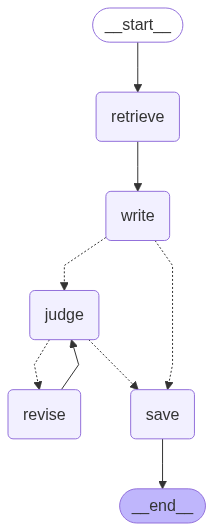

In [235]:
app

In [250]:
app = build_graph()
architecture = SectionSpec(
        name="System Architecture",
        query="Architecture overview of the project: high-level system architecture and component responsibilities",
        route="both",
        k_text=10,
        k_code=20,
        guidance="Focus on the bigger as well as smaller picture.",
        additional_context=""""
You are helping write the **System Architecture** section for a technical project.

You will be given:
- Project name & brief description — What the system does.
- Key goals — What it is designed to achieve.
- Key technologies — Languages, frameworks, tools, services.
- Any special constraints — e.g., latency, security, budget.
- Retrieved repository content tagged as architecture, diagrams, component descriptions, configuration files, and tech stack details, requirement.txt.

Output format (only include what is available or inferred):

1. **System Architecture Diagram (Mermaid)**
   - Use `flowchart TD` or `graph LR`.
   - Include the flow of the main applicaiton.
   - Mark the title as Infered from the code.
   - Mark missing elements as (Information not available in repository).

2. **Key Components Table**
   - Columns: Component | Responsibility | Technology | Evidence
   - Write proper technology with package, frameworks, modules, etc.
   - Include component which are acutally used.
   - Only what is in the repo or inferred. Don't assume anything.

3. **Detailed Explanation**
   - Be very detailed about each step techincally. Details like what technique used for example clustering, RAG, few-shot-prompting etc, 
   also if you can you can write in pointwise manner. If you think there is less information about some step, write less information about this but dont skips any step.
   - Explain important python functions too.
   - Also explain the technical method used for example clustering, RAG, few-shot-prompting etc.
   - What kind of data is used for training, validation, testing etc. If json, then show a sample json, only if available. No guessing.
   - Mark missing or inferred steps clearly per rules.

4. **Deployment View**
   - Tell the entire thing for eg. Local dev setup, staging, production topology etc.
   - Mark inferred items clearly per rules.

5. **Scalability & Reliability**
   - Only repo data or clearly marked inference.

6. **Security & Compliance**
   - Authentication, authorization, data protection, logging.
   - Mark inferred items clearly per rules.

7. **Trade-offs & Alternatives**
   - Key design choices with pros/cons.
   - Mark inferred items clearly per rules.

8. **Assumptions & Constraints**
   - Supported use cases, limits, boundaries.
   - Mark inferred items clearly per rules.

9. **Risks & Mitigations**
   - Technical and operational risks with prevention/recovery strategies.
   - Mark inferred items clearly per rules.

10. **Observability & Quality**
    - Metrics, tracing, alerts, testing approach.

11. **Future Extensions**
    - Possible evolutions, integrations, optimizations.
    - Mark inferred items clearly per rules.
"""
)

print("Wrote:", app.invoke({"spec": architecture})["out_path"])

Wrote: docs/system_architecture.md


In [ ]:
app = build_graph()
technologies = SectionSpec(
        name="Technologies Used",
        query="Installation prerequisites and versions",
        route="both",
        k_text=5,
        k_code=5,
        guidance="""
        Just list the technologies used in a way like
        Languages: Python, JavaScript
        Frameworks: Flask, React
        Packages: NumPy, Pandas
        """,
        additional_context=""
)

#print("Retreive", app.invoke({"spec": technologies}, print_mode="debug"))
print("Wrote:", app.invoke({"spec": technologies})["out_path"])